In [381]:
import numpy as np
import os
from CoPhaser import utils
from CoPhaser import plotting
import sys

sys.path.insert(0, "../set_up")  # add set_up path to search list

import plot_helpers
import constants

from scipy.stats import pearsonr
from scipy.sparse import csr_matrix, hstack, vstack

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import anndata
import scanpy as sc
import pickle
import pandas as pd
from scipy.ndimage import gaussian_filter

In [382]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [383]:
DATA_FOLDER = "data/"

height_ratios_scaling: [1, 1, 1, 1]


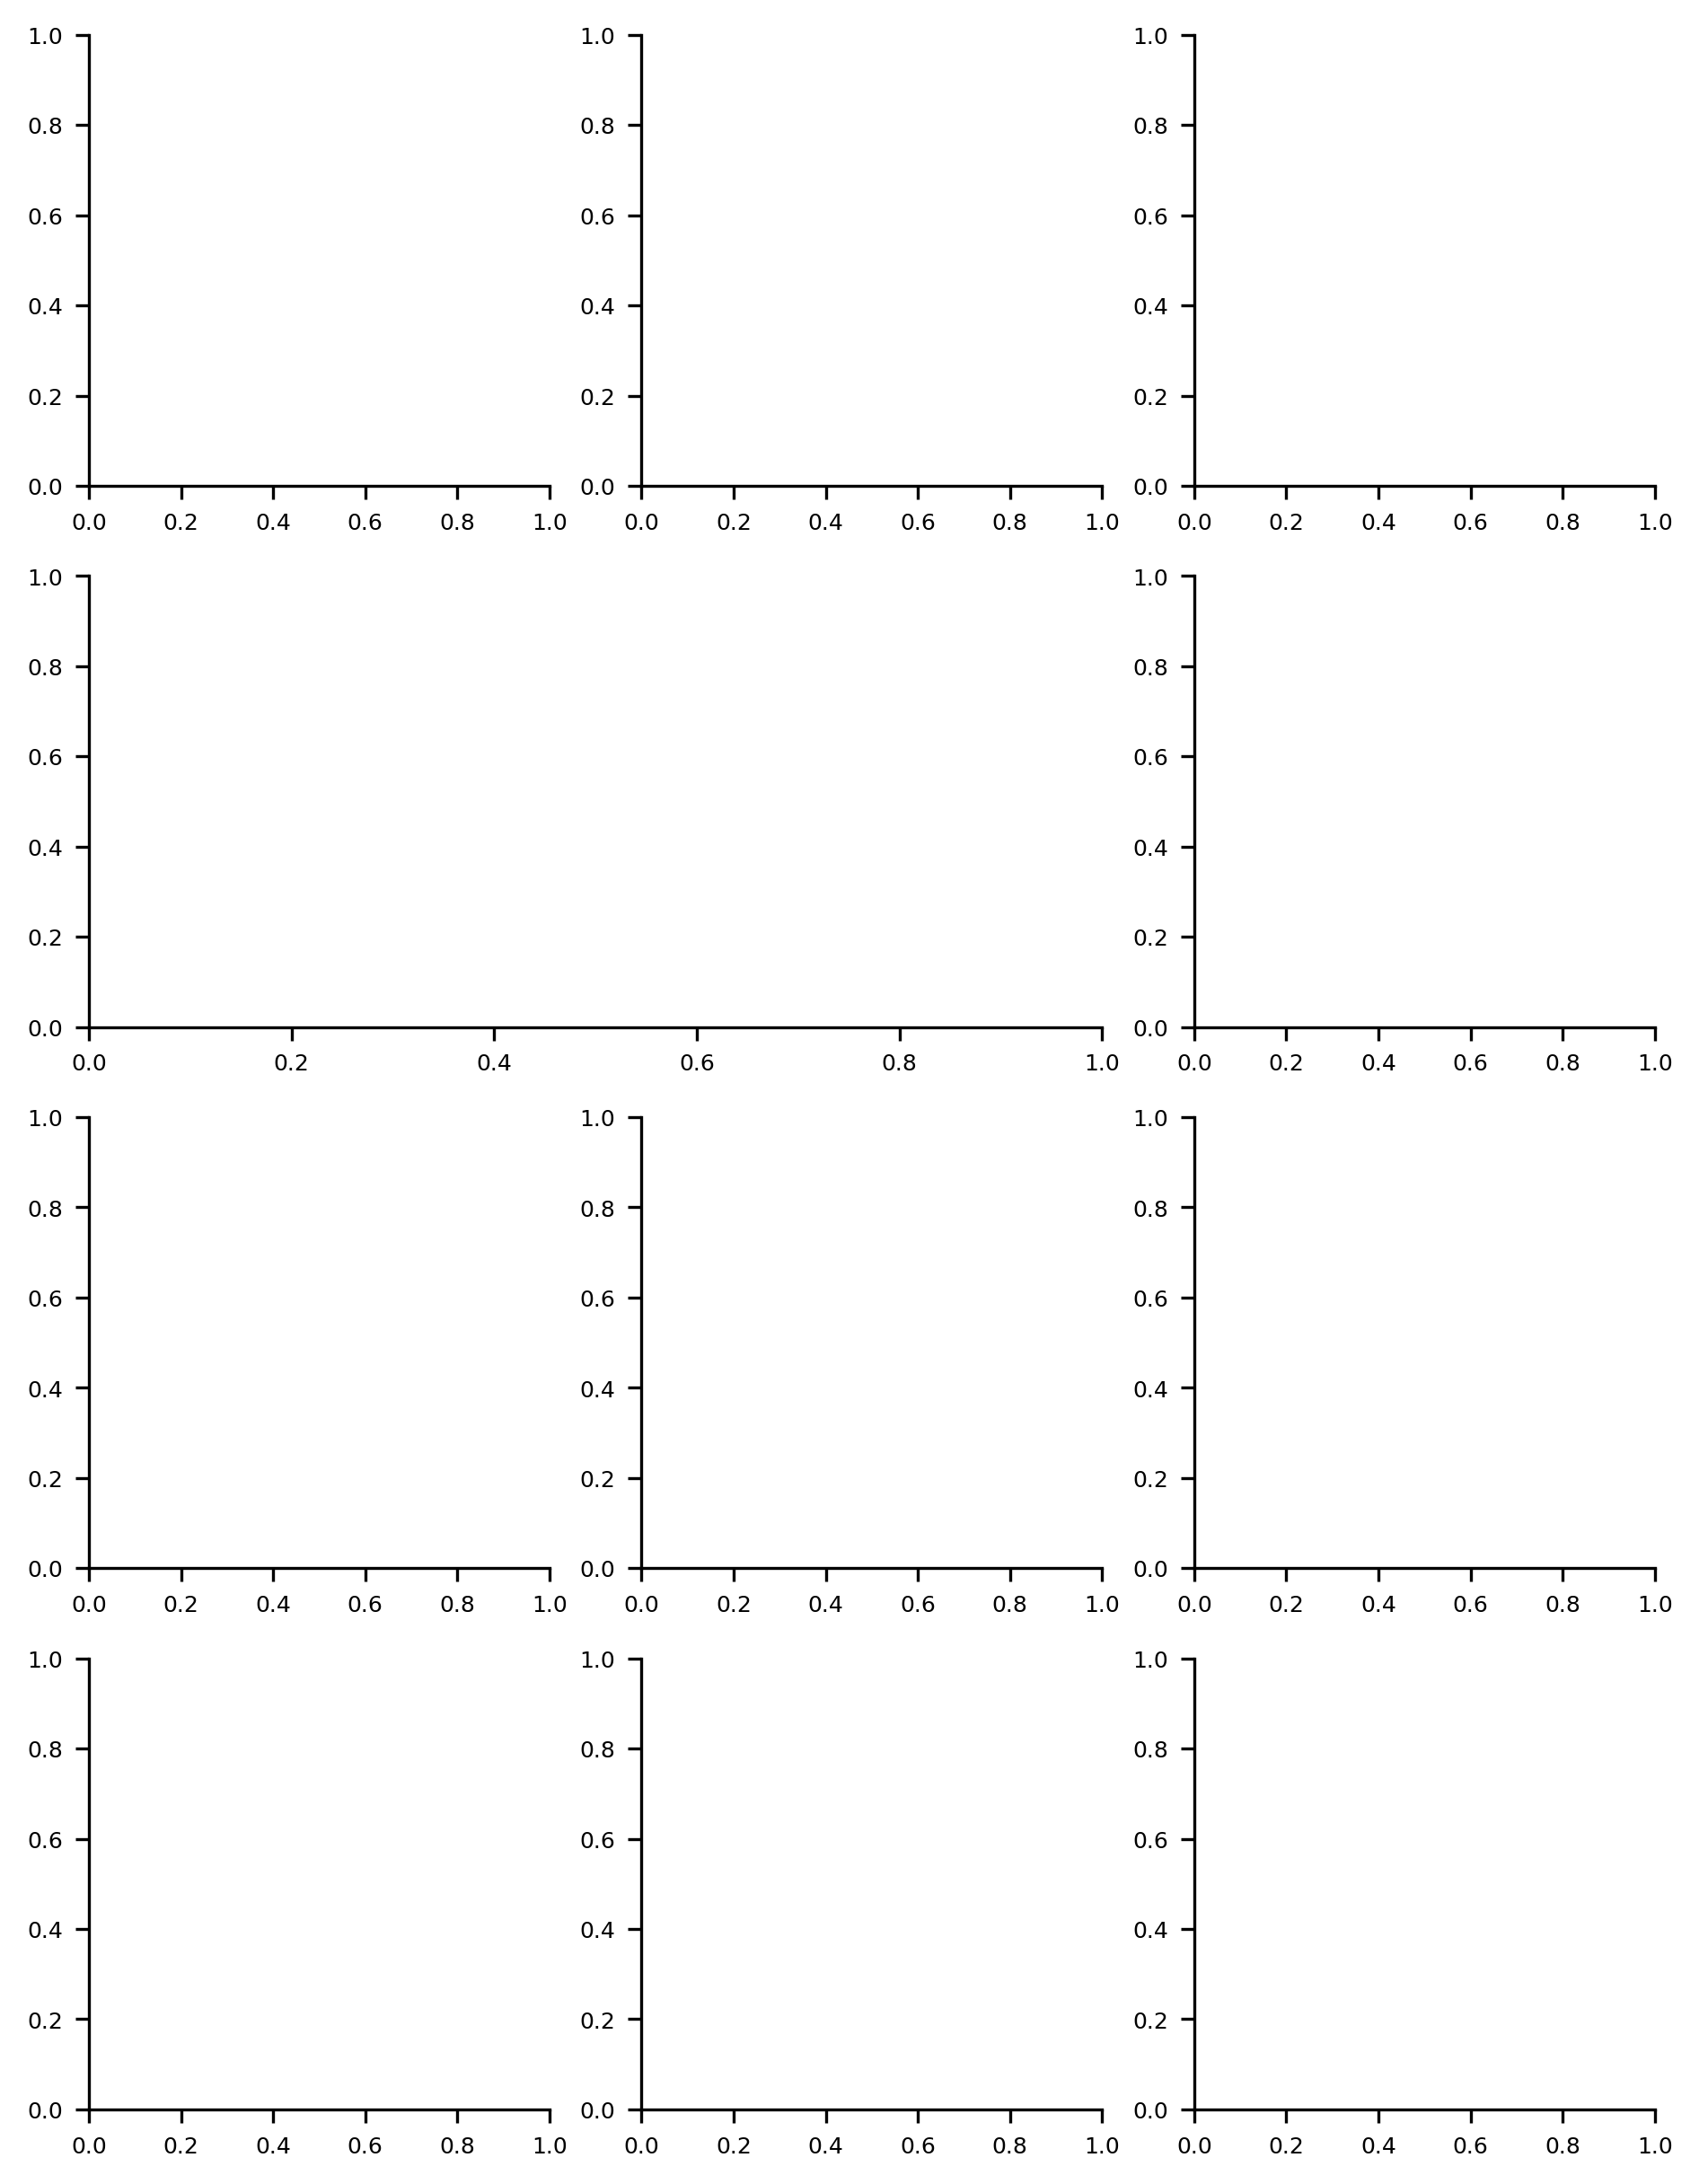

In [384]:
mosaic = [["A", "B", "C"], ["D", "D", "E"], ["F", "G", "H"], ["I", "J", "K"]]
fig, axs = plot_helpers.create_pannels(mosaic=mosaic, h_pad=0)

In [385]:
DATA_FOLDER_ADATA = "../../../data/"
adata = anndata.read_h5ad(
    f"{DATA_FOLDER_ADATA}/somite/mesodermal_progenitors_Tbx6p_names_mapped_2.h5ad"
)
i_cycling = adata.obs["cycling"]
adata = adata[i_cycling]

In [386]:
somite = pickle.load(open(os.path.join(DATA_FOLDER, "somite_res.pkl"), "rb"))
somite["projected_z"][:, 1] = somite["projected_z"][:, 1]

In [387]:
def get_gene_fractions(gene_name, adata, layer="total"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    gene_fractions = (
        adata[:, gene_name].layers[layer].toarray().flatten() / library_size
    )
    return gene_fractions


def get_genes_fractions(gene_names, adata, layer="total"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    gene_fractions = (adata[:, gene_names].layers[layer].toarray().T / library_size).T
    return gene_fractions


def plot_gene_profiles(
    gene_names,
    adata,
    inferred_phase,
    axs,
    position,
    layer="total",
    hue=None,
    legend_title=None,
):
    try:
        axs = plot_helpers.replace_mosaic_cell_with_grid(
            fig, axs, label=position, nrows=1, ncols=len(gene_names)
        )
    except:
        pass
    for i in range(len(gene_names)):
        gene_name = gene_names[i]
        gene_fractions = get_gene_fractions(gene_name, adata, layer=layer)
        _, axs[position][i] = plotting.modify_axis_labels(ax=axs[position][i], step=0.5)

        plotting.plot_smoothed_profiles(
            inferred_phase,
            np.log(gene_fractions * 1e4 + 1),
            ax=axs[position][i],
            nbins=20,
            xlabel="Inferred Phase",
            ylabel=f"Normalized Counts (log)" if i == 0 else None,
            legend=i == len(gene_names) - 1,
            hue=hue,
        )
        # set title in italic and bold
        axs[position][i].set_title(gene_name, fontstyle="italic", fontweight="bold")
        if i == len(gene_names) - 1 and legend_title is not None:
            axs[position][i].legend(title=legend_title)

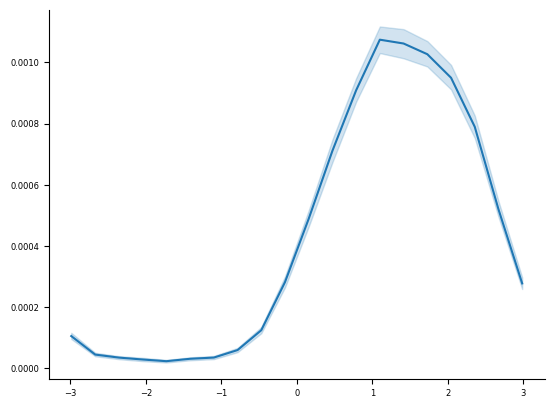

In [388]:
shift = 1.5
plotting.plot_smoothed_profiles(
    x=utils.normalize_angles(somite["thetas"] - shift),
    y=get_gene_fractions("Hes7", adata),
    ax=plt.gca(),
)
somite["thetas"] = utils.normalize_angles(somite["thetas"] - shift)

In [389]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

ax = axs["A"]


# --------------------------------------------------
# Color function (unchanged)
# --------------------------------------------------
def get_color(Wnt3a_norm, Meox1_norm, base=0.95):
    base_c = base * (1 - (Wnt3a_norm / 2 + Meox1_norm / 2))
    R = np.clip(base_c + 0.5 * Wnt3a_norm, 0, 1)
    B = np.clip(base_c + 0.5 * Meox1_norm, 0, 1)
    G = np.full_like(R, base_c)
    return np.stack([R, G, B], axis=-1)


# --------------------------------------------------
# Extract expressions
# --------------------------------------------------
Wnt3a_expr = (
    adata[:, "Wnt3a"].X.toarray().flatten()
    if hasattr(adata[:, "Wnt3a"].X, "toarray")
    else adata[:, "Wnt3a"].X.flatten()
)
Meox1_expr = (
    adata[:, "Meox1"].X.toarray().flatten()
    if hasattr(adata[:, "Meox1"].X, "toarray")
    else adata[:, "Meox1"].X.flatten()
)

# Normalize
Wnt3a_norm = (Wnt3a_expr - Wnt3a_expr.min()) / (Wnt3a_expr.max() - Wnt3a_expr.min())
Meox1_norm = (Meox1_expr - Meox1_expr.min()) / (Meox1_expr.max() - Meox1_expr.min())

# Compute colors
colors = get_color(Wnt3a_norm, Meox1_norm, base=0.95)

# Sort for correct overplotting
sort_index = np.argsort(Wnt3a_norm + Meox1_norm)
z_sorted = somite["projected_z"][sort_index]
colors_sorted = colors[sort_index]


# --------------------------------------------------
# Plot on EXISTING ax (from mosaic)
# --------------------------------------------------
scatter = ax.scatter(z_sorted[:, 0], z_sorted[:, 1], c=colors_sorted, s=5, linewidths=0)

ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_title("z Space")
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])


# --------------------------------------------------
# Create colorbar axis linked to ax
# --------------------------------------------------
divider = make_axes_locatable(ax)
ax_cbar = divider.append_axes("right", size="5%", pad=0.1)

# Build custom colormap
n_steps = 256
Wnt3a_line = np.concatenate([np.linspace(1, 0, n_steps // 2), np.zeros(n_steps // 2)])
Meox1_line = np.concatenate([np.zeros(n_steps // 2), np.linspace(0, 1, n_steps // 2)])

cmap = mpl.colors.ListedColormap(get_color(Wnt3a_line, Meox1_line, base=0.95))

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=1))
sm.set_array([])

# Draw colorbar *into cax*
cbar = plt.colorbar(sm, cax=ax_cbar, orientation="vertical")
# cbar.set_label("Meox1 / Wnt3a")
cbar.set_ticks([])
ax_cbar.text(
    0.5,
    -0.02,
    "Posterior",
    ha="center",
    va="top",
    transform=ax_cbar.transAxes,
)

ax_cbar.text(
    0.5,
    1.02,
    "Anterior",
    ha="center",
    va="bottom",
    transform=ax_cbar.transAxes,
)

cbar.outline.set_visible(False)

<Figure size 640x480 with 0 Axes>

In [390]:
ax = axs["B"]
# split spectral such as embryo to ID 12 are in first half and then go to the end
palette_first = sns.color_palette("magma", n_colors=24)
n_end = adata.obs["embryo_id"].nunique() - 12
palette_end = sns.color_palette("magma", n_colors=n_end * 2)
palette = palette_first[:12] + palette_end[n_end:]
plotting.plot_z_space_paper(
    somite["projected_z"][:, 0],
    somite["projected_z"][:, 1],
    ax=ax,
    hue=adata.obs["embryo_id"].str.split("_").str[1].astype(int),
    xlabel="UMAP 1",
    ylabel="UMAP 2",
    cmap=palette,
    alpha=0.5,
    size=2,
)
divider = make_axes_locatable(ax)
ax_cbar = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(
        cmap=mpl.colors.ListedColormap(palette),
        norm=mpl.colors.Normalize(vmin=1, vmax=32),
    ),
    cax=ax_cbar,
    orientation="vertical",
)
cbar.set_label("#Somites")
cbar.outline.set_visible(False)

<Figure size 640x480 with 0 Axes>

In [391]:
def convert_f_coeffs_to_one_harm(f_coeffs):
    # f_coeffs is a matrix of shape (n_genes, n_harmonics*2), with columns:
    # [a1, b1, a2, b2, ..., an, bn]
    n_genes, n_coeffs = f_coeffs.shape
    n_harmonics = n_coeffs // 2
    # We will convert to a matrix of shape (n_genes, 2), with columns [a1, b1], taking the max phase and amplitude as max-min
    phases = np.linspace(-np.pi, np.pi, 100)
    gene_expressions = np.zeros((n_genes, len(phases)))
    for i in range(n_harmonics):
        a = f_coeffs[:, 2 * i]
        b = f_coeffs[:, 2 * i + 1]
        for j, phase in enumerate(phases):
            gene_expressions[:, j] += a * np.cos(phase * (i + 1)) + b * np.sin(
                phase * (i + 1)
            )
    # Now, for each gene, find the phase that gives the maximum expression and return amp and phase
    amp = np.max(gene_expressions, axis=1) - np.min(gene_expressions, axis=1)
    max_phase_indices = np.argmax(gene_expressions, axis=1)
    max_phases = phases[max_phase_indices]
    return np.vstack((amp, max_phases)).T


def plot_f_coeffs(df_phase_ptp, ax_label, axs=axs):
    plot_helpers.make_polar(axs, ax_label)
    ax = axs[ax_label]
    ax.scatter(
        df_phase_ptp["phase"],
        df_phase_ptp["amplitude"],
        s=df_phase_ptp["mean_fraction"] * df_phase_ptp["amplitude"] * 50000,
    )
    for i, row in df_phase_ptp.iterrows():
        if (
            row["amplitude"] > 0.5 * df_phase_ptp["amplitude"].max()
            and row["mean_fraction"] > 0.00001
        ):
            ax.text(
                row["phase"],
                row["amplitude"],
                i,
                fontsize=6,
                ha="center",
                va="center",
            )
    ax.set_xticklabels([])
    ax.set_yticks(range(0, int(df_phase_ptp["amplitude"].max()) + 1, 1))


amp_phase = convert_f_coeffs_to_one_harm(somite["f_coeff"])
mean_fraction = get_genes_fractions(somite["gene_names"], adata, layer="total").mean(
    axis=0
)
mean_fraction = pd.Series(mean_fraction, index=somite["gene_names"])
df_phase_ptp = pd.DataFrame(
    amp_phase,
    columns=["amplitude", "phase"],
    index=somite["df_rhythmic"].columns.to_list()[:-1],
)
df_phase_ptp = df_phase_ptp.loc[somite["gene_names"]]
df_phase_ptp["mean_fraction"] = mean_fraction.loc[df_phase_ptp.index]
plot_f_coeffs(df_phase_ptp, ax_label="C")

In [392]:
df_phase_ptp_mixed = df_phase_ptp.copy()
prior_phase = pd.read_csv("mouse_somite_s41586-020-2144-9.csv", index_col=0)
df_phase_ptp_mixed["phase"] = prior_phase.loc[df_phase_ptp_mixed.index, "phase"]

height_ratios_scaling: [1]


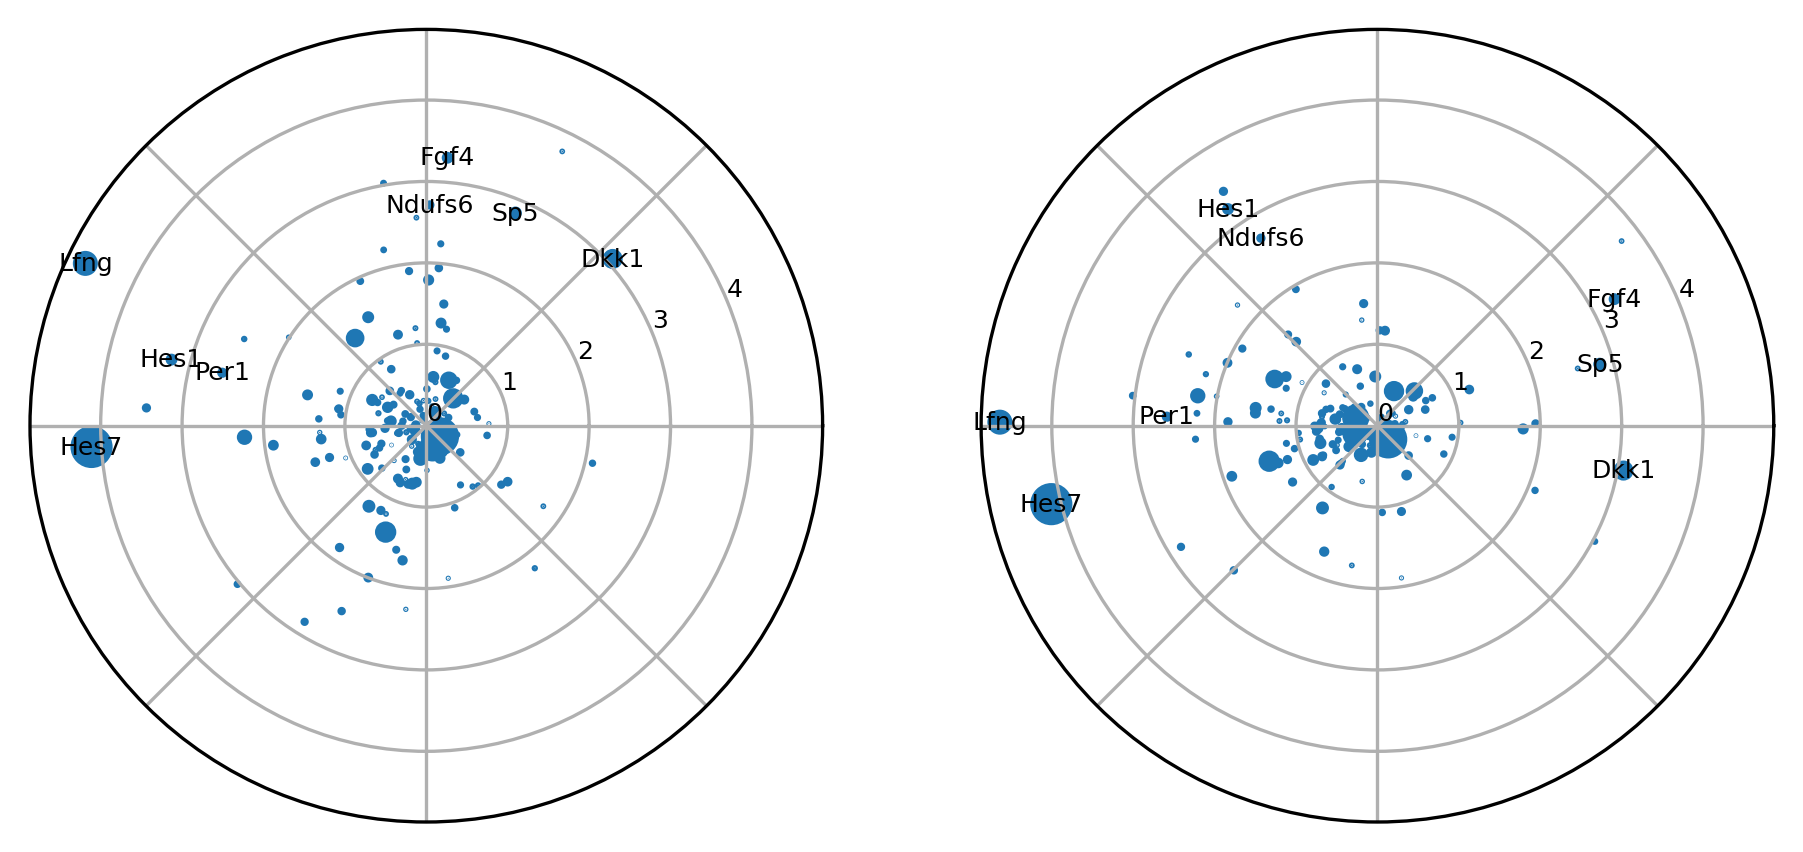

In [393]:
fig_tmp, axs_tmp = plot_helpers.create_pannels(mosaic=[["A", "B"]], h_pad=0)
plot_f_coeffs(df_phase_ptp, ax_label="A", axs=axs_tmp)
plot_f_coeffs(df_phase_ptp_mixed, ax_label="B", axs=axs_tmp)

In [394]:
df_phase_ptp_mixed

,amplitude,phase,mean_fraction
Efna1,2.237648,2.976528,6.426600e-05
Lfng,4.638461,3.132256,1.079663e-04
Per1,2.589032,3.098905,1.637343e-05
Dusp4,1.507023,3.038825,3.519110e-05
Hes1,3.233435,2.174680,2.112305e-05
...,...,...,...
Baz1a,0.704974,-1.037278,7.152525e-05
Fv1,1.893216,-1.414255,6.707514e-07
Zfp212,0.528972,1.979807,2.341005e-05
Itm2c,0.217386,2.615935,8.836371e-05


In [395]:
plot_f_coeffs(df_phase_ptp, ax_label="C")

In [396]:
plot_gene_profiles(
    ["Hes7", "Lfng", "Dkk1"],
    adata,
    somite["thetas"],
    axs,
    position="D",
)

In [397]:
adata.obs.columns

Index(['cell_id', 'keep', 'day', 'embryo_id', 'experimental_batch',
       'inferred_theta', 'leiden_label', 'is_TB', 'umap_density', 'cycling',
       'posterior_anterior_axis', 'leiden'],
      dtype='object')

In [398]:
categories = [str(i) for i in range(12)]

# initialize as categorical with all possible labels
adata.obs["post_ant_model"] = pd.Categorical(
    values=[np.nan] * adata.n_obs,
    categories=categories,
)
cat_dtype = adata.obs["post_ant_model"].dtype

for emb in adata.obs["embryo_id"].unique():
    i = adata.obs["embryo_id"] == emb
    adata.obs.loc[i, "post_ant_model"] = pd.qcut(
        somite["projected_z"][i, 1],
        q=12,
        labels=categories,
    ).astype(cat_dtype)

/tmp/ipykernel_559623/68983726.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["post_ant_model"] = pd.Categorical(


In [399]:
adata.obs

,cell_id,keep,day,embryo_id,experimental_batch,inferred_theta,leiden_label,is_TB,umap_density,cycling,posterior_anterior_axis,leiden,post_ant_model
run_4_P2-01A.CGTCTTCCTTAGGCCATAG-0,run_4_P2-01A.CGTCTTCCTTAGGCCATAG,yes,E8.5,embryo_7,run_4,2.660846,6,False,0.434719,True,-5.489056,6,4
run_4_P2-01A.CGTTGATCTCTTGGTAATG-0,run_4_P2-01A.CGTTGATCTCTTGGTAATG,yes,E8.5,embryo_9,run_4,1.409665,0,False,0.783213,True,0.468246,0,6
run_4_P2-01A.AATACCGAATGGCGAACTCG-0,run_4_P2-01A.AATACCGAATGGCGAACTCG,yes,E8.5,embryo_10,run_4,0.696209,10,True,0.246459,True,-3.276564,10,0
run_4_P2-01A.CGTAGGCTTTTAGGACCGG-0,run_4_P2-01A.CGTAGGCTTTTAGGACCGG,yes,E8.5,embryo_12,run_4,2.054003,6,False,0.652259,True,-3.345171,6,3
run_4_P2-01A.AGGCTCGTTGTCCTACTTG-0,run_4_P2-01A.AGGCTCGTTGTCCTACTTG,yes,E8.5,embryo_5,run_4,-3.081058,6,False,0.611459,True,-3.299475,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
run_17_PD-12H_S384.GTCTATGGTGGCTATGACT-2,run_17_PD-12H_S384.GTCTATGGTGGCTATGACT,yes,E10.0,embryo_31,run_17,-2.959944,3,False,0.873810,True,1.029600,3,10
run_17_PD-12H_S384.TTGAGTCCTTCAATCGCAT-2,run_17_PD-12H_S384.TTGAGTCCTTCAATCGCAT,yes,E9.75,embryo_27,run_17,0.707837,3,False,0.881814,True,-1.731523,3,7
run_17_PD-12H_S384.AACCGCTGTACGAGGACCT-2,run_17_PD-12H_S384.AACCGCTGTACGAGGACCT,yes,E10.0,embryo_31,run_17,2.269552,3,False,0.695147,True,2.182405,3,9
run_17_PD-12H_S384.GATCGACCTTAACTGGTTA-2,run_17_PD-12H_S384.GATCGACCTTAACTGGTTA,yes,E9.75,embryo_26,run_17,-2.816136,1,False,0.730408,True,1.335101,1,9


In [400]:
2**1.6

3.0314331330207964

In [401]:
from matplotlib.colors import TwoSlopeNorm


def modify_axis_labels(ax, x, y, n_bins):
    rad = ""
    if np.max(abs(x)) <= np.pi:
        ax.set_xticks([-np.pi, np.pi])
        ax.set_xticklabels(["-π", "π"])
        x_bin_edges = np.linspace(-np.pi, np.pi, n_bins, endpoint=True)
    else:
        ax.set_xticks([])
        x_bin_edges = np.linspace(np.min(x), np.max(x), n_bins)
    if np.max(abs(y)) <= np.pi:
        ax.set_yticks([-np.pi, np.pi])
        ax.set_yticklabels(["-π", "π"])
        y_bin_edges = np.linspace(-np.pi, np.pi, n_bins, endpoint=True)
    else:
        ax.set_yticks([])
        y_bin_edges = np.linspace(np.min(y), np.max(y), n_bins)
    return (x_bin_edges, y_bin_edges)


def compute_PMI(x, y, bins, sigma):
    # Compute 2D histogram
    H, xedges, yedges = np.histogram2d(x, y, bins=bins)

    # Circular Gaussian smoothing
    H_smooth = gaussian_filter(H, sigma=(sigma, sigma), mode="wrap")

    # Normalize along x-axis (each column sums to 1)
    eps = 1e-9  # small constant to avoid log(0)

    Px = H_smooth.sum(axis=1, keepdims=True)
    Py = H_smooth.sum(axis=0, keepdims=True)

    Pxy = H_smooth / H_smooth.sum()
    Px = Px / H_smooth.sum()
    Py = Py / H_smooth.sum()

    PMI = np.log2((Pxy + eps) / (Px @ Py + eps))
    return PMI, xedges, yedges


def plot_PMI(x, y, ax, n_bins=10, sigma=0.5, double_plot=False, min_value=np.log2(1.5)):
    bins = modify_axis_labels(ax, x, y, n_bins)
    PMI, xedges, yedges = compute_PMI(x, y, bins, sigma)
    if double_plot:
        PMI = np.hstack((np.vstack((PMI, PMI)), np.vstack((PMI, PMI))))
        xedges = np.concatenate((xedges, xedges[:-1] + np.max(xedges)))
        yedges = np.concatenate((yedges, yedges[:-1] + 2 * np.pi))

    vmin = min(-min_value, np.min(PMI))
    vmax = max(min_value, np.max(PMI))

    norm = TwoSlopeNorm(
        vmin=vmin,
        vcenter=0.0,
        vmax=vmax,
    )

    im = ax.pcolormesh(
        xedges,
        yedges,
        PMI.T,
        cmap="coolwarm",
        norm=norm,
    )

    divider = make_axes_locatable(ax)
    ax_cbar = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(
        im,
        cax=ax_cbar,
        orientation="vertical",
    )
    cbar.outline.set_visible(False)
    cbar.set_ticks([np.min(PMI), 0, np.max(PMI)])
    # set labels as round numbers
    cbar.set_ticklabels(
        [f"{np.round(np.min(PMI), 1)}", "0", f"{np.round(np.max(PMI), 1)}"]
    )

In [402]:
ax = axs["E"]
sns.lineplot(
    x=adata.obs["post_ant_model"],
    y=somite["lambda"].flatten(),
    ax=ax,
)
ax.set_xticks([])
ax.set_xlabel("Posterior-Anterior Axis")
ax.set_ylabel("Amplitude (λ)")

Text(1244.2156862745096, 0.5, 'Amplitude (λ)')

In [403]:
def line_cost(offset, xedges, yedges, PMI, sigma=0.1):
    x_centers = (xedges[:-1] + xedges[1:]) / 2
    y_centers = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers, indexing="ij")  # shape matches PMI

    # slope wraps 2π over x range
    m = 2 * np.pi / (xedges[-1] - xedges[0])

    # circular difference
    Y_shifted = (Y - (m * X + offset) + np.pi) % (2 * np.pi) - np.pi

    # Gaussian weight
    W = np.exp(-(Y_shifted**2) / (2 * sigma**2))

    # want to align with positive PMI, avoid negative PMI
    cost = -np.sum(PMI * W)
    return cost

In [404]:
from scipy.optimize import minimize_scalar

results = {}
for id in adata.obs["embryo_id"].unique():
    i = adata.obs["embryo_id"] == id
    PMI, xedges, yedges = compute_PMI(
        adata.obs.loc[i, "post_ant_model"].astype(int),
        somite["thetas"][i],
        bins=10,
        sigma=1,
    )
    res = minimize_scalar(
        lambda b: line_cost(b, xedges, yedges, PMI, sigma=0.5),
        bounds=(-2 * np.pi, 2 * np.pi),
        method="bounded",
    )
    optimal_offset = res.x
    results[id] = utils.normalize_angles(optimal_offset)

In [405]:
# shift thetas based on optimal offsets
somite["thetas_aligned"] = somite["thetas"].copy()
results = pd.DataFrame.from_dict(results, orient="index", columns=["optimal_offset"])
for id in results.index:
    i = adata.obs["embryo_id"] == id
    somite["thetas_aligned"][i] = utils.normalize_angles(
        somite["thetas"][i] - results.loc[id, "optimal_offset"] + np.pi
    )
ax = axs["H"]
plot_PMI(
    adata.obs["post_ant_model"].astype(int),
    somite["thetas_aligned"],
    n_bins=25,
    ax=ax,
    sigma=1,
    double_plot=False,
)
ax.set_yticks([])
ax.set_title("Aligned")
ax.set_xlabel("Posterior-Anterior")
ax.set_ylabel("Somite Clock Phase")

/tmp/ipykernel_559623/1542598720.py:71: UserWarning: Adding colorbar to a different Figure <Figure size 2250x3000 with 16 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(


Text(1244.2156862745096, 0.5, 'Somite Clock Phase')

<Figure size 640x480 with 0 Axes>

In [406]:
ax = axs["F"]
plot_PMI(
    adata.obs["post_ant_model"].astype(int),
    somite["thetas"],
    ax=ax,
    n_bins=25,
    sigma=1,
    double_plot=False,
)
ax.set_title("Unaligned")
ax.set_xlabel("Posterior-Anterior")
ax.set_ylabel("Somite Clock Phase")

/tmp/ipykernel_559623/1542598720.py:71: UserWarning: Adding colorbar to a different Figure <Figure size 2250x3000 with 17 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(


Text(13.33333333333329, 0.5, 'Somite Clock Phase')

<Figure size 640x480 with 0 Axes>

In [407]:
# plot repartition of optimal offsets
# _, ax = plt.subplots(subplot_kw={"projection": "polar"})
plot_helpers.make_polar(axs, "G")
ax = axs["G"]
sns.scatterplot(
    x=results["optimal_offset"],
    y=np.ones_like(results["optimal_offset"]),
    s=50,
    palette=palette,
    hue=results.index.str.split("_").str[1].astype(int),
    ax=ax,
    legend=False,
)
ax.set_yticks([])
ax.set_ylim(0, 1.1)
ax.set_xticklabels([])
ax.set_xlabel("")
ax.set_title("Optimal Offsets per Embryo")

Text(0.5, 1.0, 'Optimal Offsets per Embryo')

In [ ]:
import pkg_resources
import CoPhaser

ccg_path = pkg_resources.resource_filename(
    CoPhaser.__name__, "resources/CCG_annotated.csv"
)
df_ccg = pd.read_csv(ccg_path, index_col=0)
df_ccg = df_ccg[df_ccg["Primary name"].str.capitalize().isin(adata.var_names)]
df_ccg["Peaktime"].value_counts().sort_index()

Peaktime
G1      43
G1/S    27
G2      80
G2/M    28
M       67
S       22
Name: count, dtype: int64

In [409]:
# open cell cycle results
cc_results = pickle.load(
    open(os.path.join(DATA_FOLDER, "chengxiang_cell_cycle_results.pkl"), "rb")
)
cc_results["inferred_theta"]

array([ 0.26361632, -1.1967854 ,  1.0943902 , ..., -1.9528079 ,
        2.473696  ,  1.9306271 ], dtype=float32)

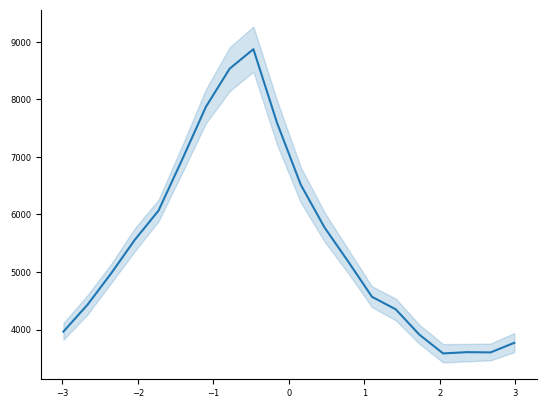

In [410]:
i_cycling = [g in adata.obs.index for g in cc_results["cell_indices"]]
plotting.plot_smoothed_profiles(
    x=utils.normalize_angles(cc_results["inferred_theta"][i_cycling]).flatten(),
    y=adata.layers["total"].sum(axis=1).A1,
    ax=plt.gca(),
)

In [411]:
adata.obs["CC_phase"] = "na"
cc_phase = cc_results["inferred_theta"][i_cycling]
adata.obs.loc[
    (cc_phase >= -0.25 * np.pi / 2) & (cc_phase < 0.25 * np.pi / 2), "CC_phase"
] = "G1"
adata.obs.loc[
    (cc_phase >= 0.25 * np.pi / 2) & (cc_phase < 0.25 * np.pi), "CC_phase"
] = "G1/S"
adata.obs.loc[(cc_phase >= 0.25 * np.pi) | (cc_phase < -0.75 * np.pi), "CC_phase"] = "S"
adata.obs.loc[(cc_phase >= -0.75 * np.pi) & (cc_phase < -0.5 * np.pi), "CC_phase"] = (
    "G2"
)
adata.obs.loc[
    (cc_phase >= -0.5 * np.pi) & (cc_phase < -0.25 * np.pi / 2), "CC_phase"
] = "M"
df_tmp = adata.obs.groupby("post_ant_model")["CC_phase"].value_counts(normalize=True)
ax = axs["I"]
sns.lineplot(
    x=[int(idx[0]) for idx in df_tmp.index],
    y=df_tmp.values,
    hue=[idx[1] for idx in df_tmp.index],
    ax=ax,
    hue_order=["G1", "G1/S", "S", "G2", "M"],
)
ax.set_xlabel("Posterior-Anterior Axis")
ax.set_xticks([])
ax.set_ylabel("Fraction of Cells")

/tmp/ipykernel_559623/1629117599.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_tmp = adata.obs.groupby("post_ant_model")["CC_phase"].value_counts(normalize=True)


Text(13.33333333333329, 0.5, 'Fraction of Cells')

In [412]:
import numpy as np

phase_bins = [
    (-0.25 * np.pi / 2, 0.25 * np.pi / 2, "G1", "#1f77b4"),
    (0.25 * np.pi / 2, 0.25 * np.pi, "G1/S", "#ff7f0e"),
    (0.25 * np.pi, np.pi, "S", "#2ca02c"),
    (-np.pi, -0.75 * np.pi, "S", "#2ca02c"),
    (-0.75 * np.pi, -0.5 * np.pi, "G2", "#d62728"),
    (-0.5 * np.pi, -0.25 * np.pi / 2, "M", "#9467bd"),
]

In [413]:
x = somite["thetas"]
y = cc_results["inferred_theta"][i_cycling]
ax = axs["K"]
plotting.modify_axis_labels(ax=ax, axis="both", step=0.5)
plot_PMI(x, y, ax=ax, sigma=0.5, n_bins=15)
ax.set_ylabel("")
ax.set_xlabel("Somite Clock Phase")
ax.set_yticks([])
from matplotlib.transforms import blended_transform_factory

# transform: x in axes coords, y in data coords
trans = blended_transform_factory(ax.transAxes, ax.transData)

bar_x = -0.03  # position just left of the axis
bar_width = 0.02  # width of the color strip

for y0, y1, label, color in phase_bins:
    ax.fill_betweenx(
        [y0, y1], bar_x, bar_x + bar_width, transform=trans, color=color, clip_on=False
    )
    ax.text(
        bar_x - 0.01,
        0.5 * (y0 + y1),
        label,
        transform=trans,
        ha="right",
        va="center",
    )

/tmp/ipykernel_559623/1542598720.py:71: UserWarning: Adding colorbar to a different Figure <Figure size 2250x3000 with 18 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(


<Figure size 640x480 with 0 Axes>

In [414]:
df_cc_fits = utils.get_ptp_phase(cc_results["df_rhythmic"])

In [415]:
df_cc_fits = df_cc_fits.loc[
    [g for g in df_ccg["Primary name"].str.capitalize() if g in df_cc_fits.index]
]

In [416]:
df_cc_fits["phase_annotated"] = df_ccg.set_index(
    df_ccg["Primary name"].str.capitalize()
).loc[df_cc_fits.index, "Peaktime"]

In [417]:
ax = axs["J"]
plotting.plot_smoothed_profiles(
    x=somite["thetas"],
    y=np.median(
        get_genes_fractions(
            df_cc_fits[df_cc_fits["phase_annotated"].isin(["G1", "G1/S"])].index, adata
        ),
        axis=1,
    ),
    ax=ax,
    nbins=10,
)
plotting.modify_axis_labels(ax=ax, axis="x", step=0.5)
ax.set_xlabel("Somite Clock Phase")
ax.set_ylabel("Normalized Counts (log)")
ax.set_title("G1/G1-S Genes")

Text(0.5, 1.0, 'G1/G1-S Genes')

Figure saved to: /home/maxine/Documents/paychere/CoPhaser/paper/figures/figure_6_somite_python.svg


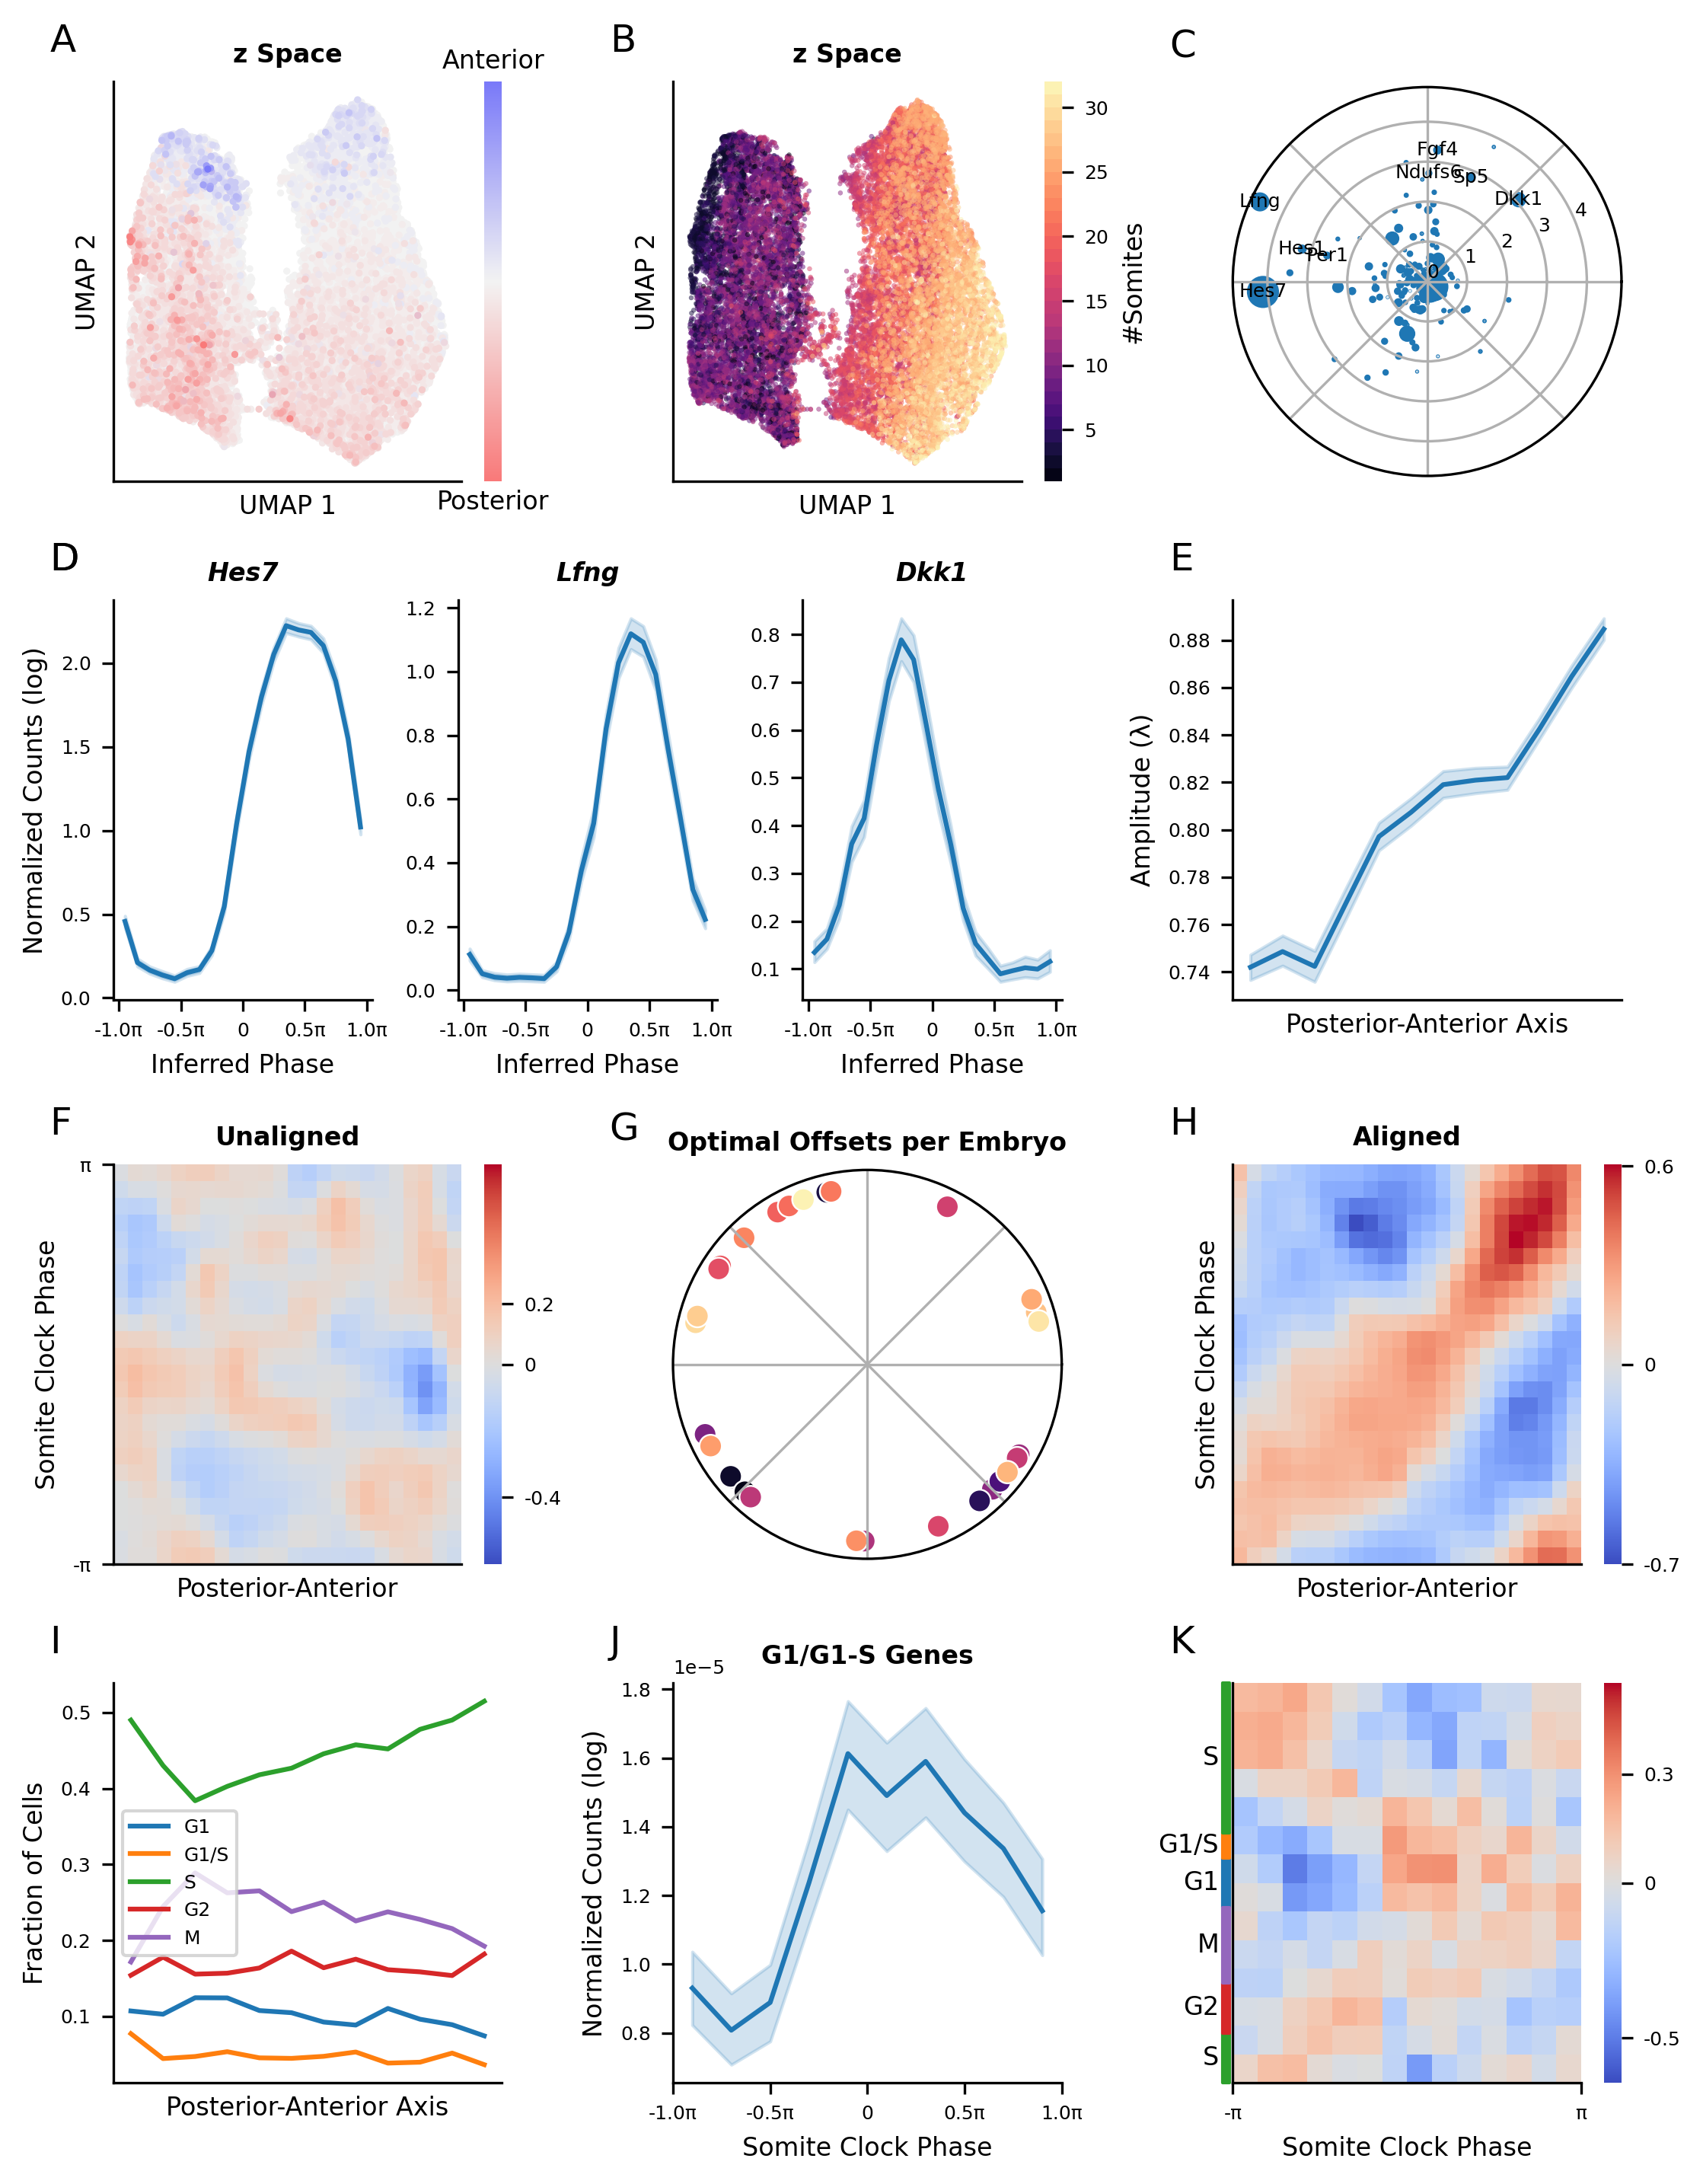

In [ ]:
plot_helpers.label_panels_mosaic(fig, axs, mosaic)
plot_helpers.save_figure(
    fig,
    axs,
    "figure_7_somite_python",
    to_remove_vertically=[-0.02, 0, -0.02],
    mosaic=mosaic,
)